In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pspy import so_map, so_dict, pspy_utils, so_mcm, so_spectra
from pspipe_utils import pspipe_list, kspace
import scipy.linalg

In [2]:
base_dir = Path("/global/cfs/projectdirs/act/data/xzackli/PSpipe/project/data_analysis/")
param_dict_file = base_dir / "paramfiles" / "global_dr6_v4.dict"
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]

d = so_dict.so_dict()
d.read_from_file(param_dict_file)
lmax = d["lmax"]
binning_file = d["binning_file"]
spec_list = pspipe_list.get_spec_name_list(d, delimiter="_")  # unrolled fields
bin_lo, bin_hi, lb, bin_size = pspy_utils.read_binning_file(binning_file, lmax)
n_spec = len(spectra)
n_bins = len(bin_lo)  # number of bins is same for all spectra in block

In [3]:
# na, nb are each i.e. 'dr6_pa6_f150'
spec1 = spec_list[-1]
na, nb = spec1.split("x")
print("fields involved: ", na, nb)

fields involved:  dr6_pa6_f150 dr6_pa6_f150


The operator $T(n_a, n_b)$ is defined as the linear operator which takes a pseudo-spectrum of some polarizations between two arrays $n_a$ and $n_b$ (in dr6, this operator is independent of split) and outputs a measured spectrum.

All operators start from $\ell = 2$.

$$
T_{bl'} =  F_{bb}^{-1} P_{bl} M_{ll'}^{-1} 
$$
where $F_{bb}^{-1}$ corrects for the $k$-space filter, $P_{bl}$ is the binning operator, and $M_{ll'}^{-1}$ is the unbinned inverse mode-coupling matrix.

In [4]:
l = np.arange(2, lmax)
cltype = "Dl"
if cltype == "Dl": fac = (l * (l + 1) / (2 * np.pi))
elif cltype == "Cl": fac = l * 0 + 1
Pbl = np.zeros( (n_bins, lmax-2) )
for ibin in range(n_bins):
    loc = np.where((l >= bin_lo[ibin]) & (l <= bin_hi[ibin]))[0]
    Pbl[ibin,loc] = fac[loc] / len(loc)

In [5]:
spin_pairs = ["spin0xspin0", "spin0xspin2", "spin2xspin0", "spin2xspin2"]
mbb_inv, Bbl = so_mcm.read_coupling(prefix=f"{base_dir}/mcms/{na}x{nb}", spin_pairs=spin_pairs)

In [6]:
Pbl_pol =  scipy.linalg.block_diag(Pbl, Pbl, Pbl, Pbl)

M00 = Pbl @ mbb_inv['spin0xspin0']
M02 = Pbl @ mbb_inv['spin0xspin2']
M20 = Pbl @ mbb_inv['spin2xspin0']
M22 = Pbl_pol @ mbb_inv['spin2xspin2']

Minv_bl = scipy.linalg.block_diag(M00, M02, M02, M20, M20, M22)

In [7]:
print(d["kspace_tf_path"])

/global/cfs/cdirs/act/data/tlouis/dr6v4/kspace_tf/


In [8]:
kspace_tf_path = d["kspace_tf_path"]
surveys = d["surveys"]
spec_name = f"{na}x{nb}"

if kspace_tf_path == "analytical":
    arrays, templates, filter_dicts =  {}, {}, {}
    for sv in surveys:
        arrays[sv] = d[f"arrays_{sv}"]
        filter_dicts[sv] = d[f"k_filter_{sv}"]
        templates[sv] = so_map.read_map(str(base_dir / d[f"window_T_{sv}_{arrays[sv][0]}"]))
    kspace_transfer_matrix = kspace.build_analytic_kspace_filter_matrices(
        surveys, arrays, templates, filter_dicts, binning_file, lmax)[spec_name]
else:
    kspace_transfer_matrix = np.load(f"{kspace_tf_path}/kspace_matrix_{spec_name}.npy", allow_pickle=True)
    _, TE_corr = so_spectra.read_ps(f"{kspace_tf_path}/TE_correction_{spec_name}.dat", spectra=spectra)
    Cb_TE_corr = np.hstack([TE_corr[s] for s in spectra])

inv_kspace_mat = np.linalg.inv(kspace_transfer_matrix)

In [9]:
Finv_Minv_bl = inv_kspace_mat @ Minv_bl

/tmp/ipykernel_1546850/2408873163.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(Finv_Minv_bl[:, ::4])), aspect=25)


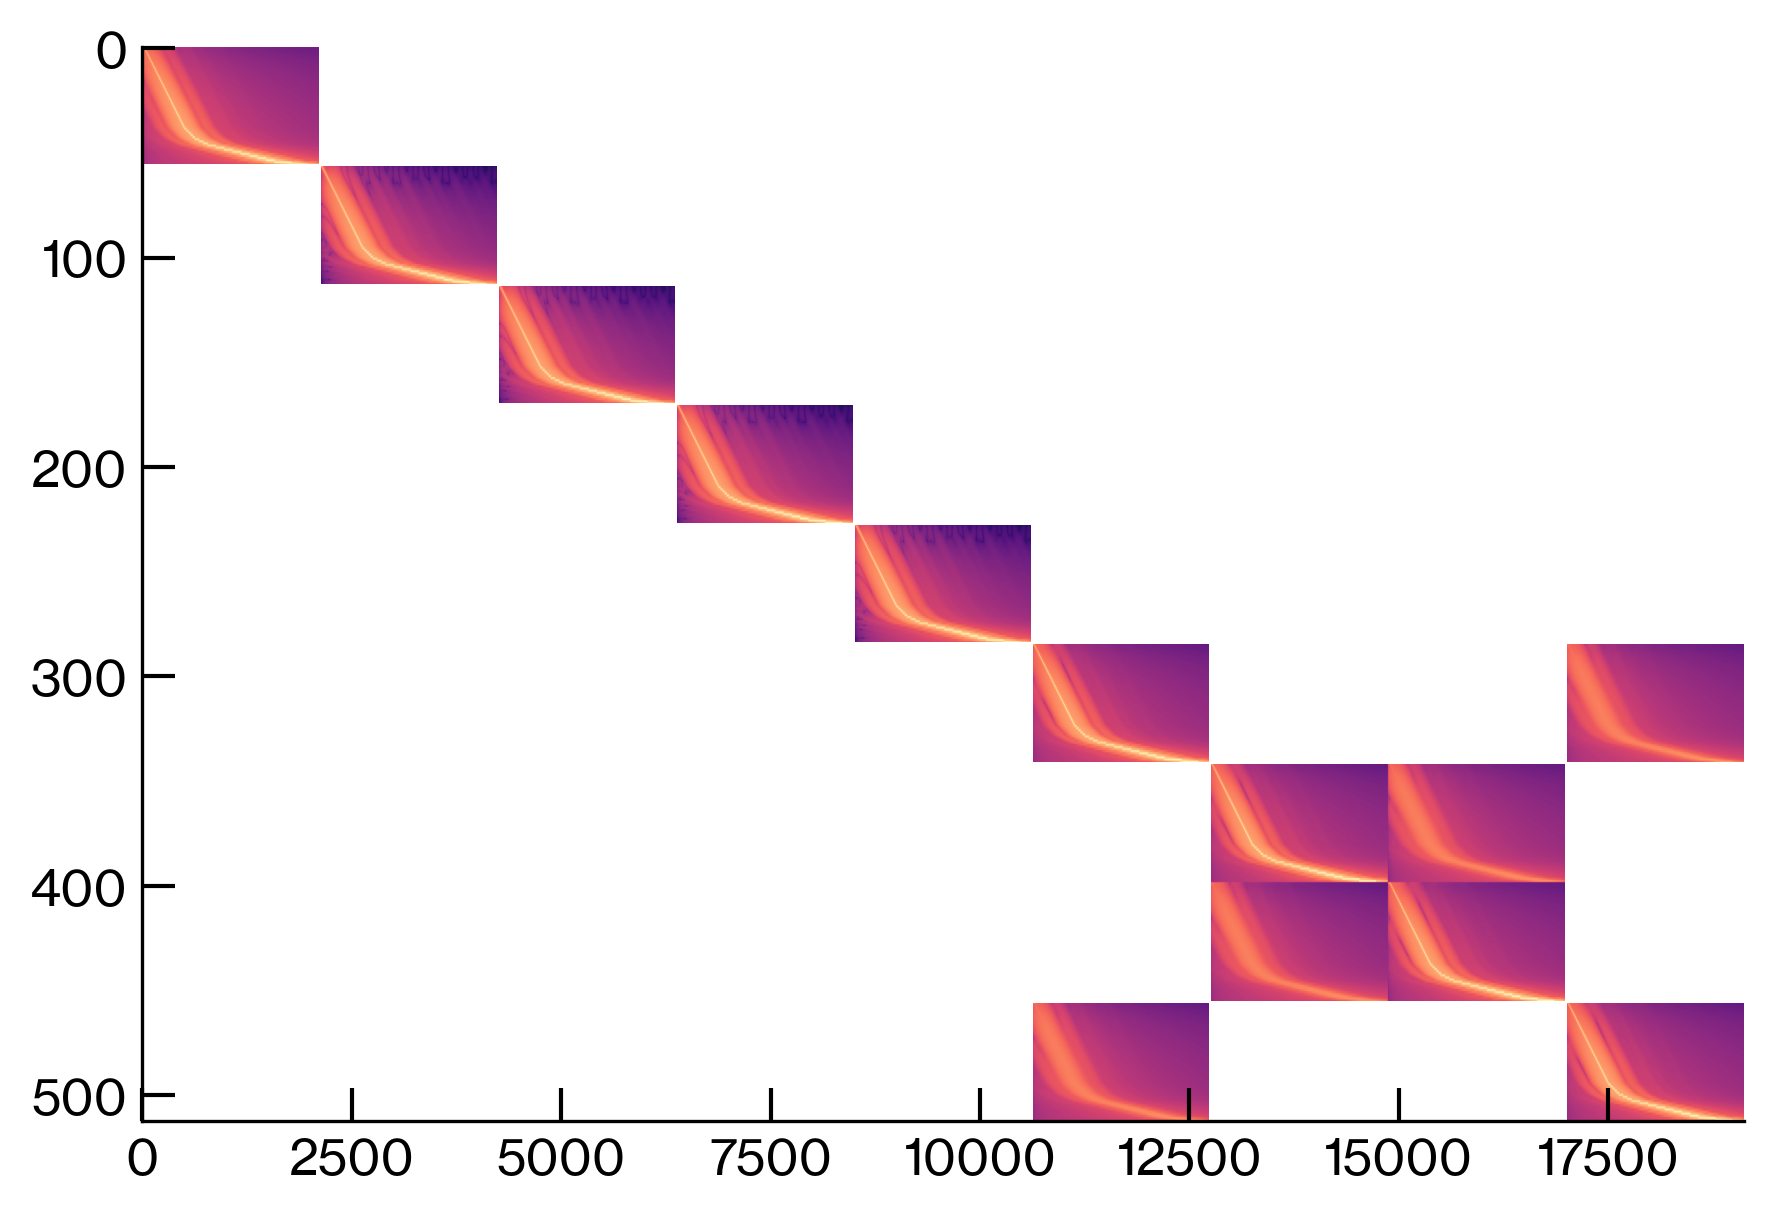

In [10]:
plt.imshow(np.log10(np.abs(Finv_Minv_bl[:, ::4])), aspect=25)

In [11]:
s1, s2 = 0, 1
specdir = "spectra"
l, pCl = so_spectra.read_ps(base_dir / specdir / f"pseudo_{na}x{nb}_{s1}{s2}.dat", spectra=spectra)
lb_ref, Cb_ref = so_spectra.read_ps(base_dir / specdir / f"Dl_{na}x{nb}_{s1}{s2}.dat", spectra=spectra)
pCl_vector = np.hstack([pCl[s][2:lmax] for s in spectra]) # makevec_ell(pCl, spectra, lmax)
pCb_ref_vector = np.hstack([Cb_ref[s][:] for s in spectra])

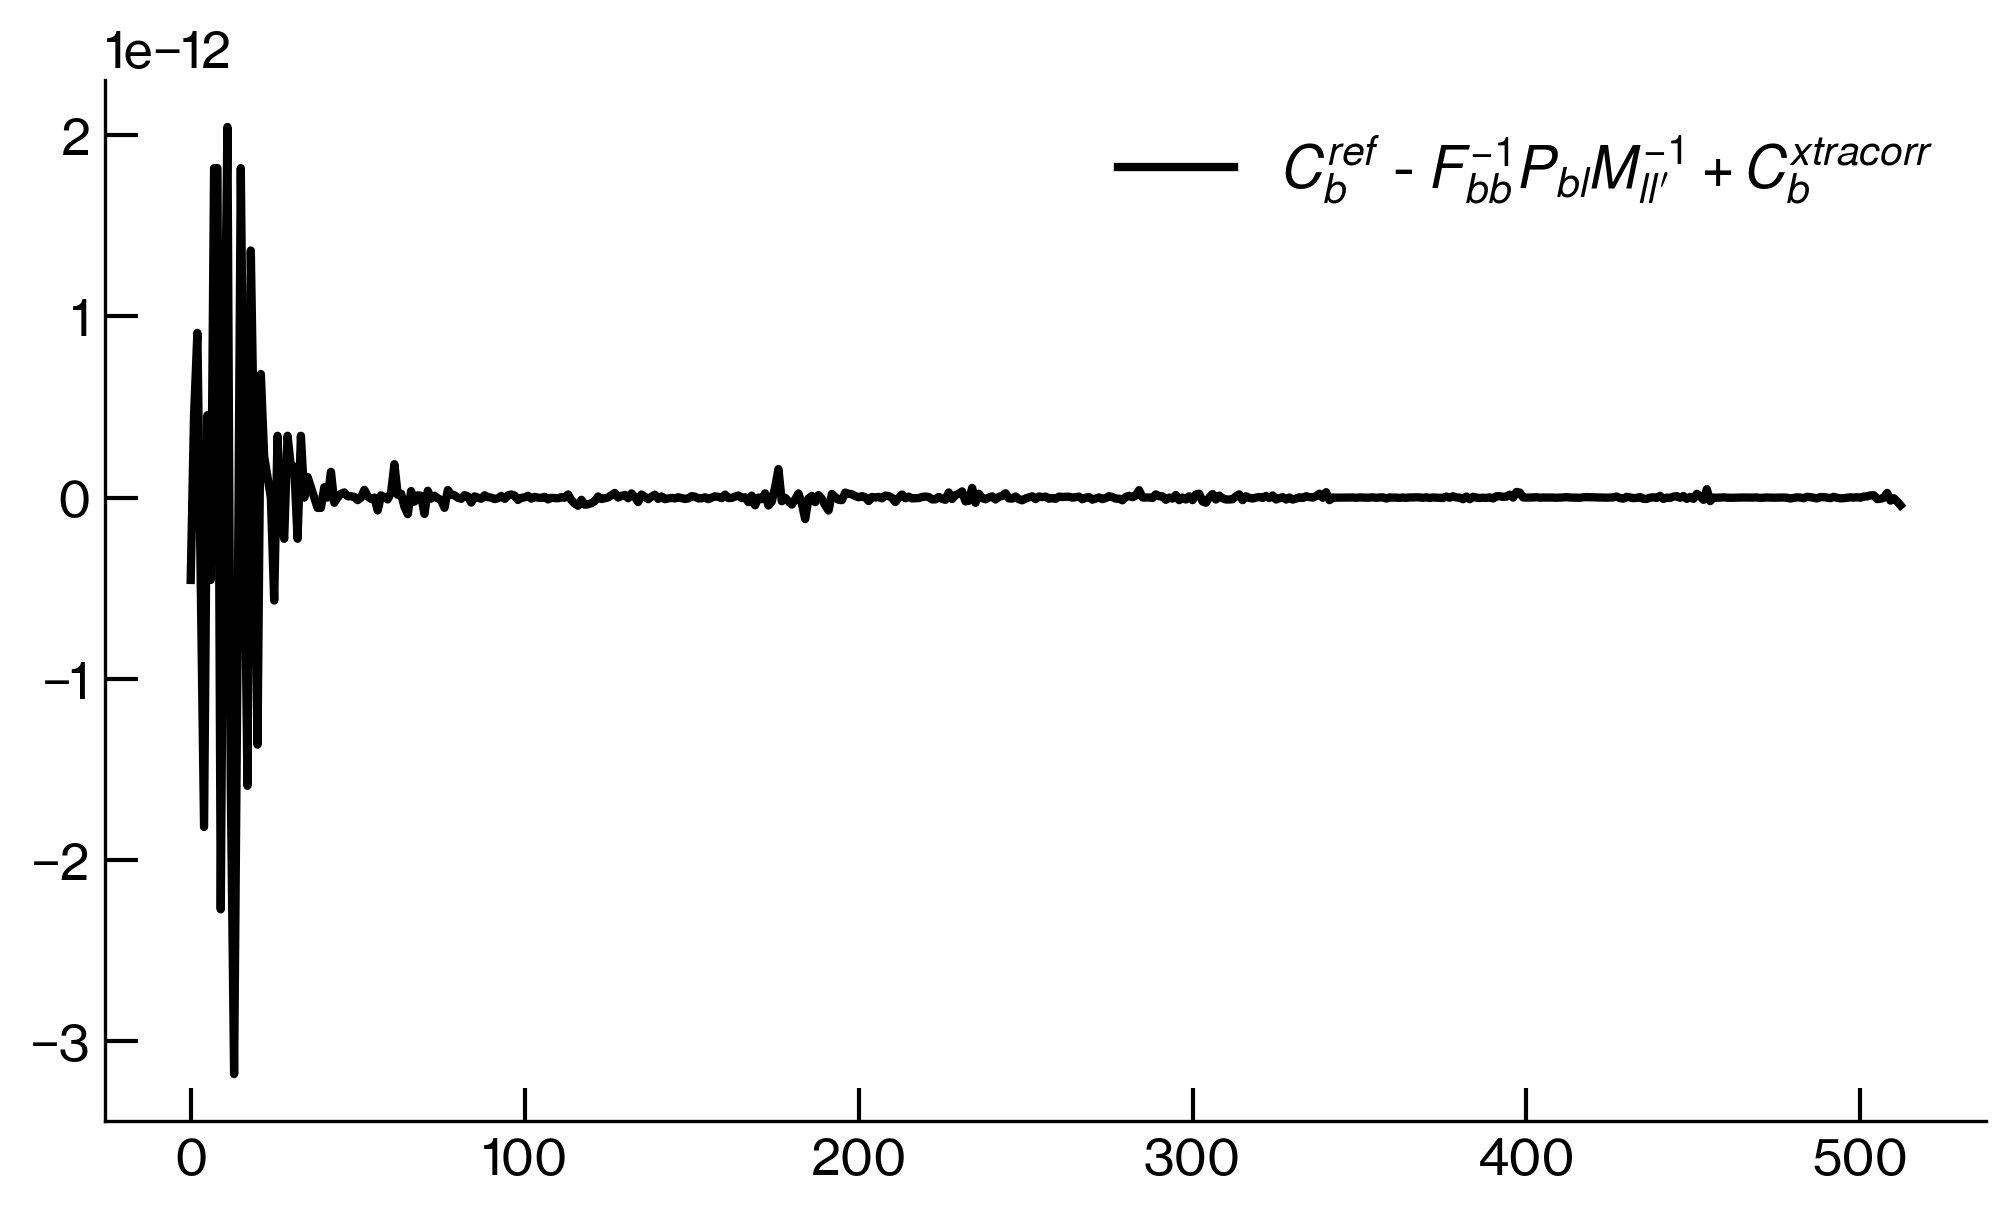

In [12]:
plt.plot(pCb_ref_vector - (Finv_Minv_bl @ pCl_vector) + Cb_TE_corr, 
         label=r"$C_b^{ref}$ - $F^{-1}_{bb} P_{bl} M^{-1}_{ll'} + C_b^{xtracorr}$")
plt.legend()

In [13]:
# check that operator on disk matches
Finv_Minv_bl_disk = np.load("/global/cfs/projectdirs/act/data/xzackli/pspipe_operators/"
                            + "Finv_Pbl_Minv_dr6_pa6_f150xdr6_pa6_f150.npy")

print( np.max(np.abs(Finv_Minv_bl_disk - Finv_Minv_bl))  / np.max(np.abs(Finv_Minv_bl_disk)) )

1.6722779422207993e-15


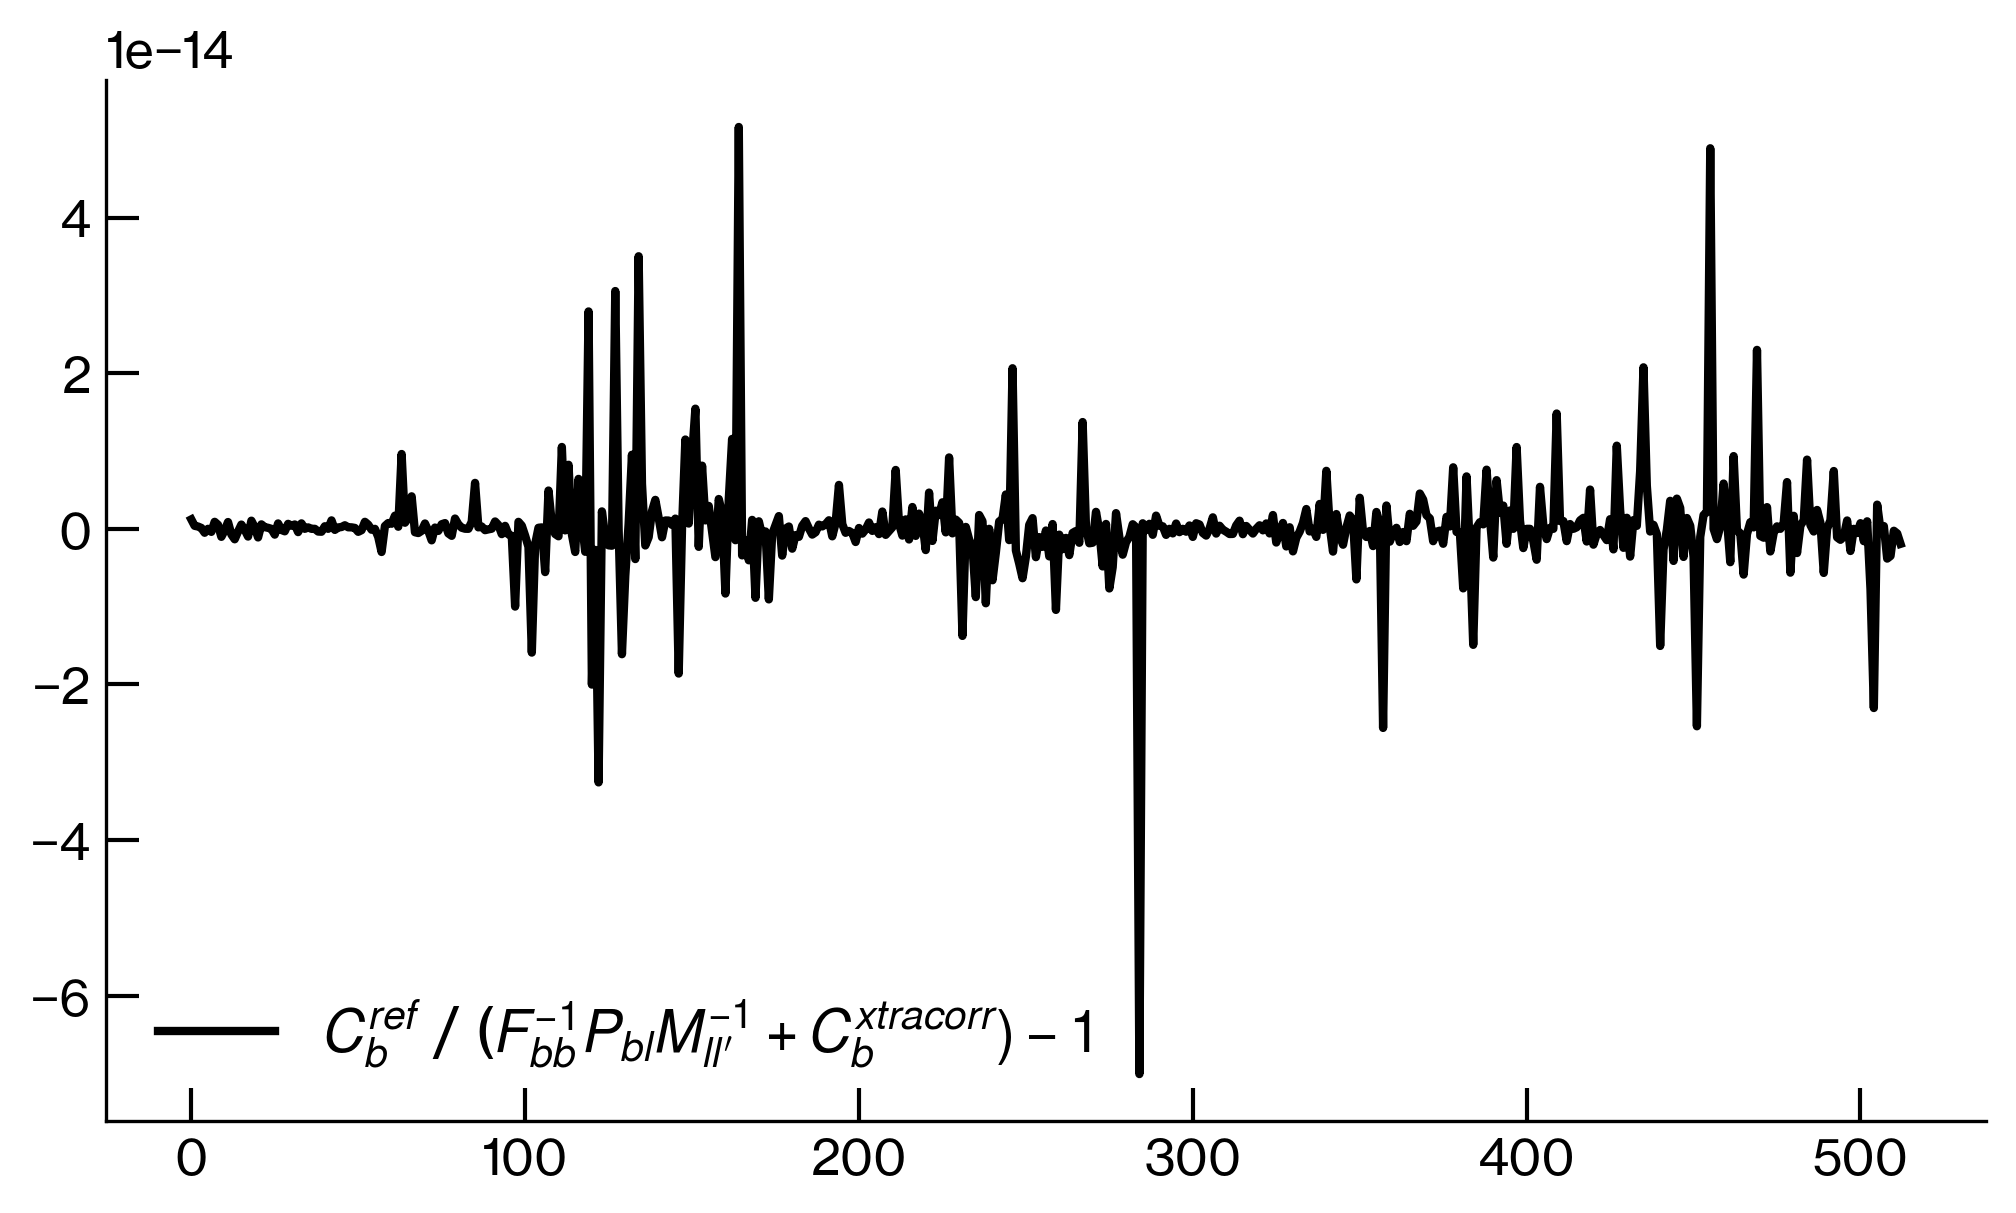

In [14]:
plt.plot((pCb_ref_vector - (Finv_Minv_bl_disk @ pCl_vector) + Cb_TE_corr) / pCb_ref_vector, 
         label=r"$C_b^{ref}$ / ($F^{-1}_{bb} P_{bl} M^{-1}_{ll'} + C_b^{xtracorr}) - 1$")
plt.legend()